<a href="https://colab.research.google.com/github/criswada/Lovelace/blob/master/Modelo_Series_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dados

In [0]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

## Visualização

In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
py.offline.init_notebook_mode(connected=True)


import seaborn as sns
import colorlover as cl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use( u'seaborn-notebook',)

## Estatística


In [9]:
pip install fitter

  Created wheel for fitter: filename=fitter-1.1.11-cp36-none-any.whl size=7020 sha256=579f888fe962eb8f64e519019926f0fed624a9361a62cabfbb39aa34b38377b4
  Stored in directory: /root/.cache/pip/wheels/fb/c2/97/2cf6c13e07eb92ca80c8d1b2c42a7ee8eefea0989a429d5665
Successfully built fitter


In [0]:
from scipy import stats as st
from fitter import Fitter

## Series Temporais

In [0]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.arima_model import ARMA, ARIMA, AR

In [0]:
import statsmodels.api as sm

## Machine Learning

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.manifold import MDS

from xgboost import XGBRegressor as XGB

## Análise Exploratória

In [0]:
def del_outl(data, m=2): #Elimina outliers
    return pd.DataFrame(data[abs(data - np.mean(data)) < m * np.std(data)], columns=["Numero"])

In [0]:
def frecuencia(df, columns):
    return (df[columns].value_counts())/df["category"].count()

In [16]:
df=pd.read_csv("GBvideos.csv")
df.shape

(38916, 16)

In [0]:
route="GB_category_id.json"
id_catg= [[],[]]

with open(route, 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_catg[0].append(int(category['id'])) 
        id_catg[1].append(category['snippet']['title'])
df=pd.DataFrame({"category_id": id_catg[0], "category": id_catg[1]}).merge(df, on="category_id", how="inner")

In [0]:
var_d=["trending_date", "channel_title",  
     "comments_disabled", "ratings_disabled", "video_error_or_removed", "category"]
var_c=["publish_time", "trending_date", "views", "likes","dislikes", "comment_count"]

In [21]:
#Recuento por frecuencia -
frecuencia(df, "category")

Music                   0.354247
Entertainment           0.234997
People & Blogs          0.075362
Film & Animation        0.066373
Howto & Style           0.049657
Sports                  0.049117
Comedy                  0.047082
Gaming                  0.046052
News & Politics         0.031551
Pets & Animals          0.013754
Science & Technology    0.013342
Education               0.011770
Autos & Vehicles        0.003709
Travel & Events         0.002473
Shows                   0.000515
Name: category, dtype: float64

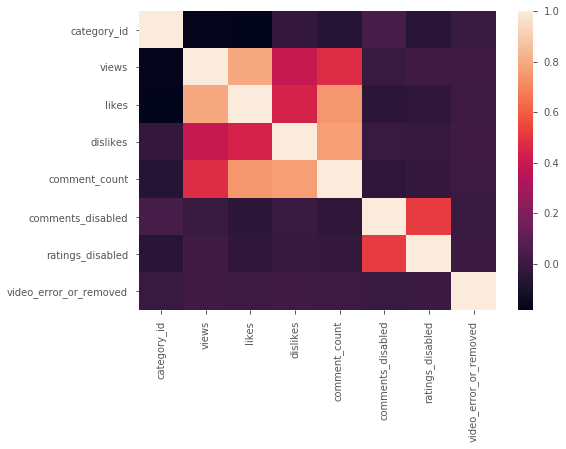

In [22]:
with plt.style.context(('ggplot')):
    sns.heatmap(df.corr())

In [0]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

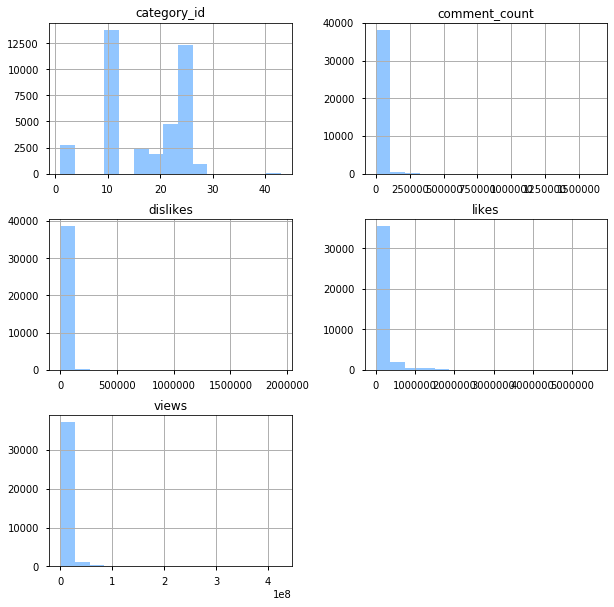

In [30]:
 with plt.style.context(('seaborn-pastel')):

#Histogramas de las variables
    df[['category_id', 'category', 'video_id', 'trending_date', 'title',
       'channel_title', 'publish_time', 'tags', 'views', 'likes', 'dislikes',
       'comment_count', 'thumbnail_link', 'description']].hist(figsize=(10,10), bins=15)

In [32]:
color=cl.scales["4"]["qual"]["Set1"]

def proyect_yt(category, columns, Homocedasticidad=None, tend=0, acf=False, plot=True):
    layout = go.Layout(title=category,
                        xaxis = dict(title = 'Data'),
                       yaxis = dict(title = "Quantidade"))
    his={}
    data=df[df["category"]==category][["trending_date",
                                       "views",
                                       "likes",
                                       "dislikes",
                                       "comment_count"
                                      ]].groupby( "trending_date").sum().copy().reset_index()
    d=[]
    
    
    for j in columns:

        if Homocedasticidad in ["log", "inv", "sqrt", "Isqrt", "Ilog"]: 
            if Homocedasticidad=="log" or Homocedasticidad=="sqrt": 
                f=lambda x: eval("np.%s(x)" %Homocedasticidad)
            elif Homocedasticidad=="Isqrt":  f=lambda x: np.sqrt(x)**-1
            elif Homocedasticidad=="Ilog":  f=lambda x: np.log(x)**-1
            else: f=lambda x: x**-1
            
            
            y_=data[j].copy().map(f)
        
        else: y_=data[j]
        
        
        if tend>0: 
            y_=pd.Series([x[0]-x[1] for x in zip(y_.iloc[::-1],
                                                 y_.iloc[::-1].iloc[tend:])]).iloc[::-1]
        trace = go.Scatter(
            y =y_ ,
            x = data["trending_date"].iloc[tend:],
         mode = 'lines+markers', name=j, line = dict(color=color[columns.index(j)]))
        
        
        d.append(trace)
        if acf==True:
            fig_pacf=tsaplots.plot_pacf(x=y_, )
            fig_pacf.set_size_inches(18.5, 10.5)
            fig_pacf.suptitle( category+" "+j.upper() , fontsize=20,  horizontalalignment= 'center')

            fig_acf=tsaplots.plot_acf(x=y_)
            fig_acf.set_size_inches(18.5, 10.5)
            fig_acf.suptitle( category +" "+j.upper() , fontsize=20)
        
        his[j+" "+str(Homocedasticidad)+str(tend)]=pd.Series(list(y_),
                                                             index=data["trending_date"].iloc[tend:])
        
        
    fig= go.Figure(data=d, layout=layout)
    if plot==True: py.offline.iplot(fig)
    return his

columns=widgets.SelectMultiple(options=["views",
                                        "likes","dislikes","comment_count"], 
                               value=("views", ), description="Seção")


category=widgets.Dropdown(options=df.category.unique(), value='Music', 
                          description='Category:')


t=widgets.IntText(
    value=0,
    description='Dif. Grado S:',
    disabled=False)


widgets.interactive(proyect_yt, columns=columns, category=category, tend=t, 
                    Homocedasticidad=["none","inv", "sqrt","log", "Isqrt", "Ilog"])

interactive(children=(Dropdown(description='Category:', index=2, options=('Film & Animation', 'Autos & Vehicle…

## Séries Temporais

In [0]:
his=proyect_yt(category="Music", Homocedasticidad="log", tend=0,columns=["views",
                                          "likes","dislikes","comment_count"], plot=False)

In [34]:
to_pre=his["likes log0"]
to_pre=to_pre.asfreq("D",fill_value=np.nan)
to_pre.index.freqstr

'D'

In [35]:
to_pre.isnull().value_counts()

False    205
True       8
dtype: int64

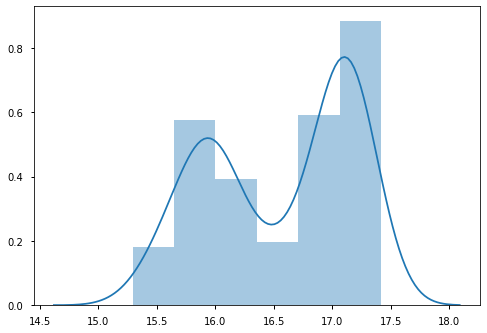

In [36]:
targe_rmvext=del_outl(np.array(to_pre.dropna()))
sns.distplot(targe_rmvext)

In [0]:
fitter=Fitter(data=targe_rmvext, verbose=False,  bins=20)
fitter.fit()

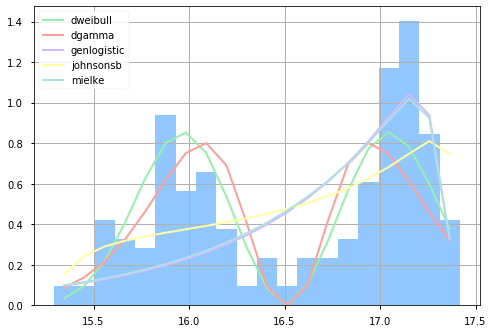

In [38]:
with plt.style.context(('seaborn-pastel')):
    fitter.summary()

In [39]:
fitter.fitted_param["triang"]


(0.9879259675978291, 15.093530445868033, 2.330103564310658)

In [0]:
to_pre.replace(np.nan, "Aqui", inplace=True)
to_pre=to_pre.map(lambda x: 
                    st.triang.rvs(*fitter.fitted_param["triang"]) if x=="Aqui"  else x)

In [41]:
res = sm.tsa.arma_order_select_ic(to_pre,max_ar=3, max_ma=3 ,ic=['aic', 'bic'], trend='nc')
print (res.aic_min_order)
print (res.bic_min_order)

(1, 1)
(1, 1)


In [42]:
model_ts=ARMA(to_pre,res.aic_min_order).fit(disp=False)
model_ts.params

const      16.427262
ar.L1.y     0.986925
ma.L1.y    -0.498116
dtype: float64

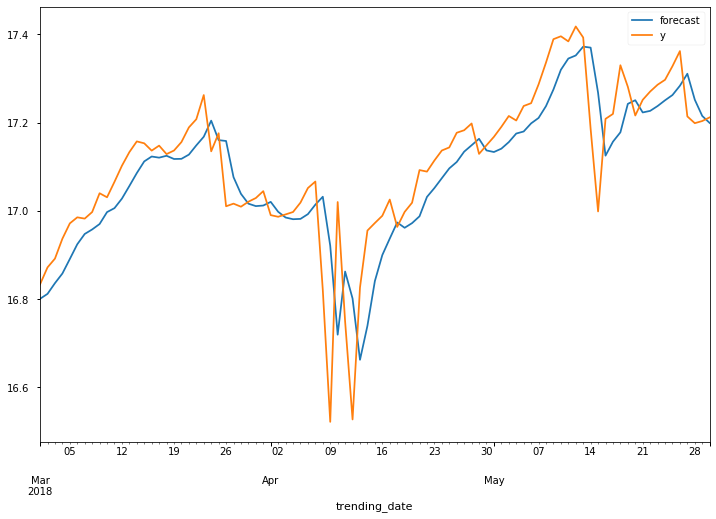

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

fig=model_ts.plot_predict(ax=ax, start="2018-03-01", end="2018-05-30", )

In [44]:
model_ts.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 -86.5625  
Dependent Variable: y                Log-Likelihood:      54.004    
Date:               2019-12-08 23:35 Scale:               1.0000    
No. Observations:   213              Method:              css-mle   
Df Model:           3                Sample:              11-14-2017
Df Residuals:       210                                   06-14-2018
Converged:          1.0000           S.D. of innovations: 0.187     
No. Iterations:     10.0000          HQIC:                -94.574   
AIC:                -100.0077                                       
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const       16.4273     0.3800    43.2261   0.0000   15.6824   17.1721
ar.L1.y      0.9869     0.0096   102.7644   0.0000    0.9681    1.0057
ma.L1.y     -0.4981     0.0668    -7.4576   0.0000   -0.6290   -0.3672
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0132             0.0000           1.0132             0.0000
MA.1            2.0076             0.0000           2.0076             0.0000
====================================================================

"""

In [0]:
aux=pd.DataFrame(to_pre.reset_index()).rename(columns={0:"target"})
#aux.to_csv("Predic_neural.csv", index=False)

## Machine Learning

In [0]:
mean_ob5=pd.Series([np.nan for x in range(5)])
desv_ob5=pd.Series([np.nan for x in range(5)])
for j in range(168):
    mean_ob5=mean_ob5.append(pd.Series(aux["target"].iloc[j:5+j].mean()))
    desv_ob5=desv_ob5.append(pd.Series(aux["target"].iloc[j:5+j].std()))
    
    
mean_ob5.reset_index(drop=True, inplace=True)
desv_ob5.reset_index(drop=True, inplace=True)

aux["desv_ob5"]=desv_ob5
aux["mean_ob5"]=mean_ob5

In [0]:
aux["year"]=aux.trending_date.dt.year
aux["month"]=aux.trending_date.dt.month
aux["day"]=aux.trending_date.dt.day

In [0]:
incre=pd.Series([np.nan for x in range(1)])

for j in range(len(aux)-1):
    
    incre=incre.append(pd.Series(aux["target"][j+1]>aux["target"][j]))

incre.reset_index(drop=True, inplace=True)
aux["incre"]=incre

In [0]:
aux["lst_ob"]=np.nan
aux["lst_ob"].iloc[1:]=list(aux.target)[:-1]

In [0]:
aux=aux[["trending_date", "mean_ob5", "incre", 
         "desv_ob5","month","year", "day","lst_ob", "target"]].dropna().reset_index(drop=True)

In [51]:
aux.head()


,trending_date,mean_ob5,incre,desv_ob5,month,year,day,lst_ob,target
0,2017-11-19,15.885246,1.0,0.029526,11,2017,19,15.928351,15.944855
1,2017-11-20,15.904518,1.0,0.030954,11,2017,20,15.944855,15.958711
2,2017-11-21,15.922095,0.0,0.031974,11,2017,21,15.958711,15.925654
3,2017-11-22,15.928500,1.0,0.027780,11,2017,22,15.925654,15.978733
4,2017-11-23,15.947261,1.0,0.022090,11,2017,23,15.978733,16.007768


In [0]:
X=aux[list(aux.columns[1:8])]
y=aux[["target"]].copy()

In [0]:
scx=MinMaxScaler()
scy=MinMaxScaler()
scx.fit(X)
scy.fit(y)
Xm=pd.DataFrame(scx.transform(X), columns=X.columns)
ym=pd.DataFrame(scy.transform(y), columns=y.columns)

In [0]:
Xt, Xv, yt, yv= train_test_split(Xm,ym, test_size=.3)


In [55]:
model_RF= RandomForestRegressor()
model_RF.fit(Xt, yt)

print (r2_score(y_pred=model_RF.predict(Xt), y_true=yt))
print (r2_score(y_pred=model_RF.predict(Xv), y_true=yv))
print (mean_absolute_error(y_pred=model_RF.predict(Xt), y_true=yt))
print (mean_absolute_error(y_pred=model_RF.predict(Xv), y_true=yv))


0.9701663704015154
0.9525378157923405
0.022578758017652408
0.039852272394377775


In [0]:
param_grid_XGB=dict(max_depth=range(100,1000,100), learning_rate=np.arange(.01,.11,.01), 
                    n_estimators=range(200,2200,200),booster=["gbtree", "gblinear", "dart"])

In [0]:
param_grid_red=dict(activation = ['identity', 'logistic', 'tanh', 'relu'],
                hidden_layer_sizes=[(y,x) for y in range(900,1000,10)
                                   for x in range(900,1000,10)], 
                learning_rate = ['constant', 'invscaling', 'adaptive'], 
                learning_rate_init=np.arange(.0001,.001,.0001))

In [0]:
param_grid_RF=dict(n_estimators=range(100,200,10), criterion=["mse",  "mae"],
                  max_depth=range(10,20), bootstrap=[True], 
                   )

In [0]:
grid= RandomizedSearchCV(model_RF,scoring="r2", verbose=True
                         , param_distributions=param_grid_RF, cv=8, n_jobs=-1)

In [60]:
grid.fit(Xt, yt)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.9s finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=None,

In [61]:
model=grid.best_estimator_
print (r2_score(y_pred=model.predict(Xt), y_true=yt))
print (r2_score(y_pred=model.predict(Xv), y_true=yv))

0.9802626743924654
0.9517244367479909


In [62]:
print (mean_absolute_error(y_pred=model.predict(Xt), y_true=yt))
print (mean_absolute_error(y_pred=model.predict(Xv), y_true=yv))

0.01874637581415172
0.0383677363751877


In [0]:
y=aux[["target"]].copy()


In [0]:
def pre(n, dia,mes,r,model):
    y_pre=r.copy()
    y_pre.rename(columns={"target":"predict"}, inplace=True)

    for k in range(n):
        
        if (dia+k)%32==31:
            mes+=1
        
        yt1=pd.DataFrame(list(map(float,[y_pre.iloc[y_pre.shape[0]-5:].mean(), np.random.choice([0,1]),
         y_pre.iloc[y_pre.shape[0]-5:].std(), mes, 2018, (dia+k)%32, y_pre.predict.iloc[y_pre.shape[0]-1]])), 
                    index=X.columns).T

        predicion=scy.inverse_transform(model.predict(pd.DataFrame(scx.transform(yt1), 
                                                    columns=X.columns)).reshape(1,1))

        y_pre=y_pre.append(pd.DataFrame(predicion[0], columns=["predict"]), ignore_index=True)
    return y_pre.iloc[r.shape[0]:]


In [65]:
X.columns


Index(['mean_ob5', 'incre', 'desv_ob5', 'month', 'year', 'day', 'lst_ob'], dtype='object')

In [0]:
aux["Predict RF"]=scy.inverse_transform(model.predict(pd.DataFrame(scx.transform(X),columns=X.columns))
                                                      .reshape(len(X),1))

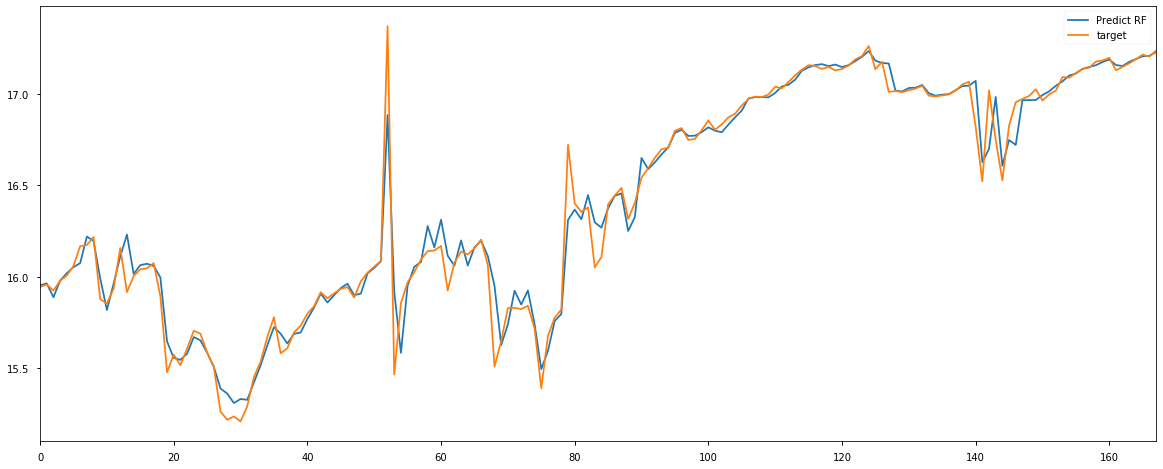

In [67]:
fig, ax = plt.subplots(figsize=(20, 8))

aux[["Predict RF", "target"]].plot(ax=ax)

In [0]:
y=aux[["target"]].copy()


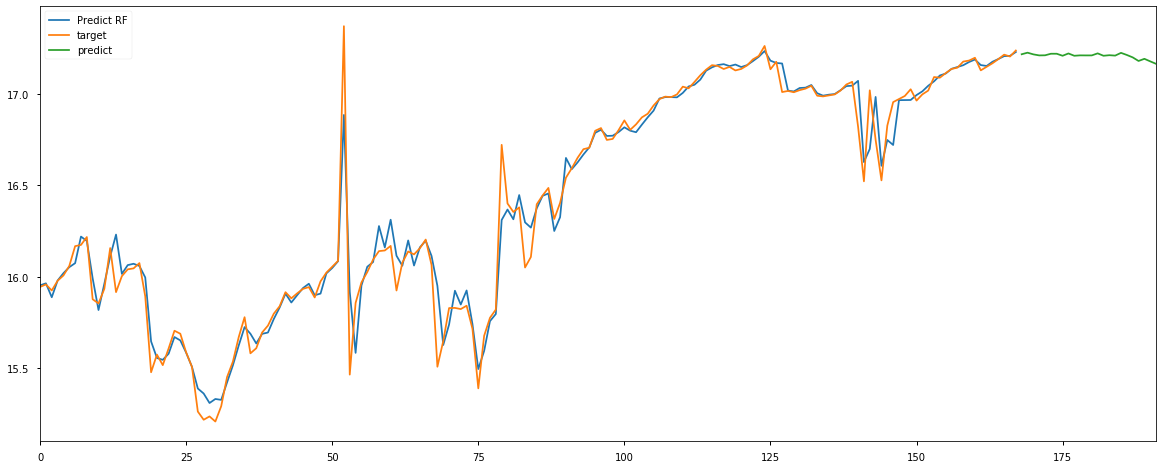

In [69]:
fig, ax = plt.subplots(figsize=(20, 8))

aux[["Predict RF", "target"]].plot(ax=ax)

pre(24, 6, 5,y,model).plot(ax=ax)

In [70]:
model_XGB= XGB()
model_XGB.fit(Xt, yt)

print (r2_score(y_pred=model_XGB.predict(Xt), y_true=yt))
print (r2_score(y_pred=model_XGB.predict(Xv), y_true=yv))

print (mean_absolute_error(y_pred=model_XGB.predict(Xt), y_true=yt))
print (mean_absolute_error(y_pred=model_XGB.predict(Xv), y_true=yv))

[23:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9958350903307076
0.9547540628484935
0.011302733022659587
0.0401769328395604


In [0]:
aux["Predict XGB"]=scy.inverse_transform(model_XGB.predict(pd.DataFrame(
                    scx.transform(X), columns=X.columns)).reshape(len(X),1))

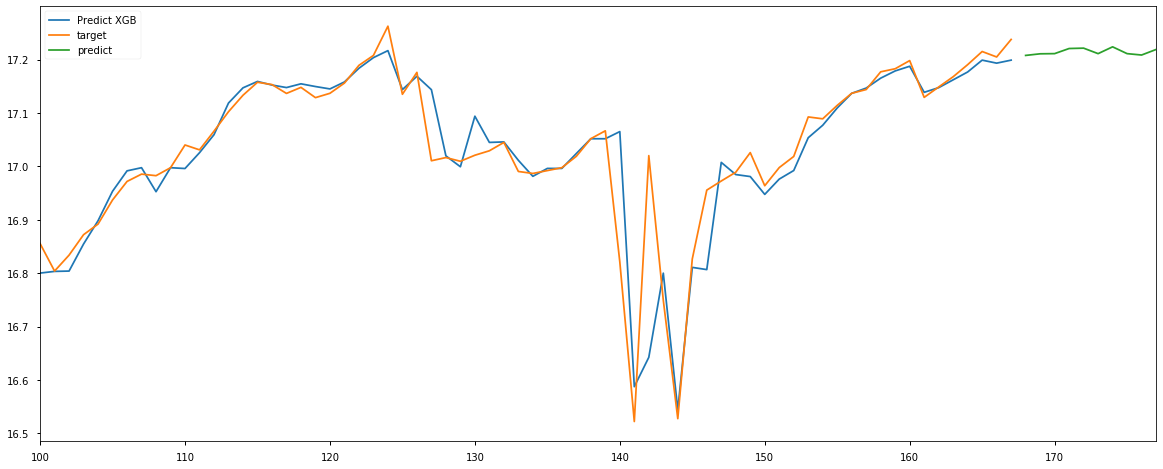

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))

aux[["Predict XGB", "target"]].iloc[100:].plot(ax=ax)
pre(10
    , 1, 1,y,model).plot(ax=ax)

In [0]:
aux=aux.merge(model_ts.predict(start="2017-11-14", end="2018-05-05").reset_index(
).rename(columns={"index":"trending_date", 0:"Predict TS"}), how="inner", on="trending_date").copy()

In [0]:
aux.to_csv("Music likes.csv")

In [75]:
print (r2_score(y_pred=aux["Predict TS"], y_true=aux["target"]))

print (mean_absolute_error(y_pred=aux["Predict TS"], y_true=aux["target"]))

0.8883782435205541
0.10959448523248619


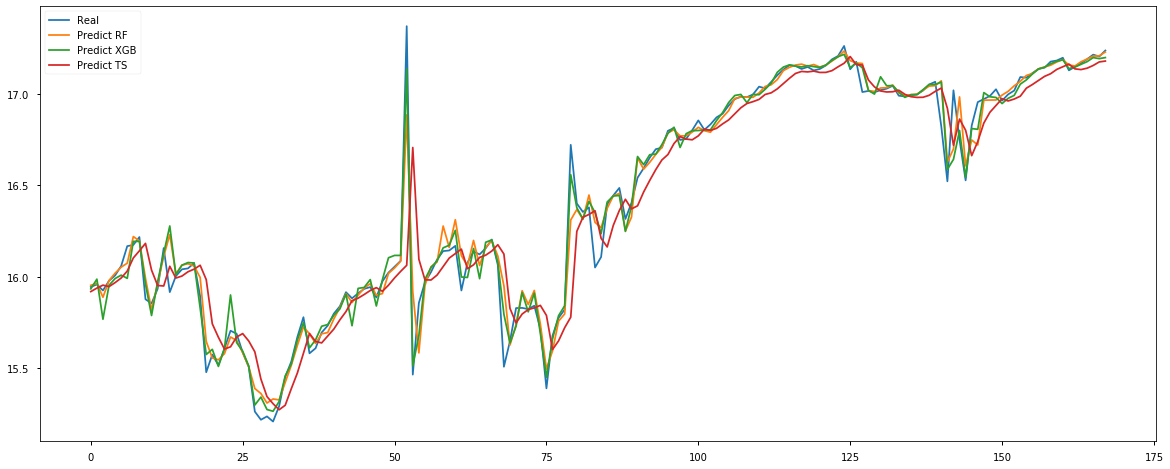

In [76]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(aux[["target", "Predict RF","Predict XGB", "Predict TS"]])
plt.legend(["Real", "Predict RF","Predict XGB", "Predict TS"])